# Powersupply stream Dataset 
contains hourly power supply of an Italy electricity company which records the power from two sources: power supply from main grid and power transformed from other grids. This stream contains three year power supply records from 1995 to 1998. The concept drifting in this stream is mainly driven by the issues such as the season, weather, hours of a day (e.g., morning and evening), and the differences between working days and weekend.

In [137]:
import pandas as pd
import numpy as np
import DataLoading
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from scipy import signal


header = {"mainGrid", "otherGrids", "hourOfDay"}
#three year power supply records from 1995 to 1998

df = pd.read_csv('powerSupplyStream.csv')
df['hourOfDay'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [65]:
start = datetime.datetime(1995, 1, 1, 0)
timestamp_list = [start + datetime.timedelta(hours=x) for x in range(len(df))]
df['timestamps'] = timestamp_list
df.info()
df.head()
len(df['timestamps'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  29928 non-null  int64         
 1   mainGrid    29928 non-null  float64       
 2   otherGrids  29928 non-null  float64       
 3   hourOfDay   29928 non-null  int64         
 4   timestamps  29928 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1.1 MB


29928

### Quick idea: you may add another column for dany and night shift and see if there is any difference This might lead to better results or stronger stationary points 
### Moreover we may group the readings from hours to hours and more over we can group it with months and also check the results (this might lead to worse results but might show some difference between the main grid and other grid )



In [174]:
df = pd.read_csv('powerSupplyStream.csv')


# create timestamps
start = datetime.datetime(1995, 1, 1, 0)
timestamp_list = [start + datetime.timedelta(hours=x) for x in range(len(df))]
df['timestamps'] = timestamp_list

# mistake in hours numbering hour 6 = 1248 instances
# #                                 9 = 1246 instances
wrongHoursIndex = 24969
for i in np.arange(len(df)-1):
    if df['hourOfDay'][i]+1 != df['hourOfDay'][i + 1] and df['hourOfDay'][i] != 23:
        print(i)
df.at[wrongHoursIndex, 'hourOfDay'] = 9
# There are 2 wrong index not only one 

df_train, df_test = train_test_split(df, test_size=3528, shuffle=False)
# hourly change in consumption
diffMain = np.append(np.array(df_train['mainGrid']), 0) - np.append(0,np.array(df_train['mainGrid']))
diffMain = diffMain[0:-1]
diffMain[0] = 0
diffOther = np.append(np.array(df_train['otherGrids']), 0) - np.append(0,np.array(df_train['otherGrids']))
diffOther = diffOther[0:-1]
diffOther[0] = 0

df_train['diffMain'] = diffMain
df_train['diffOther'] = diffOther

# df_hourDiffMain = pd.DataFrame()
# for hour in np.arange(24):
#     hourDiffList = df_train.loc[df_train['hourOfDay'] == hour]['diffMain'].values

#     df_hourDiffMain[str(hour)] = hourDiffList

24968
24969


In [189]:
df

AttributeError: 'Series' object has no attribute 'value'

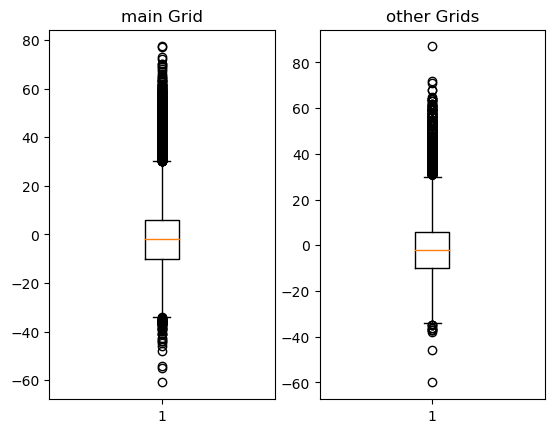

In [20]:
df_train, df_test = train_test_split(df, test_size=3528, shuffle=False)
# hourly change in consumption
diffMain = np.append(np.array(df_train['mainGrid']), 0) - np.append(0,np.array(df_train['mainGrid']))
diffMain = diffMain[0:-1]
diffMain[0] = 0
diffOther = np.append(np.array(df_train['otherGrids']), 0) - np.append(0,np.array(df_train['otherGrids']))
diffOther = diffOther[0:-1]
diffOther[0] = 0
df_hourDiffMain = pd.DataFrame()
# for hour in np.arange(24):
#     hourDiffList = df_train.loc[df_train['hourOfDay'] == hour]['diffMain'].values

#     df_hourDiffMain[str(hour)] = hourDiffList
 

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(diffMain)
ax1.set_title("main Grid")
ax2.boxplot(diffOther)
ax2.set_title("other Grids")

plt.show()


## Why did you took the difference of the reading? 
### I dont mind doing this but we need to predict the next value of the sensor not the difference between the preivous ones . Or this is what I think of 



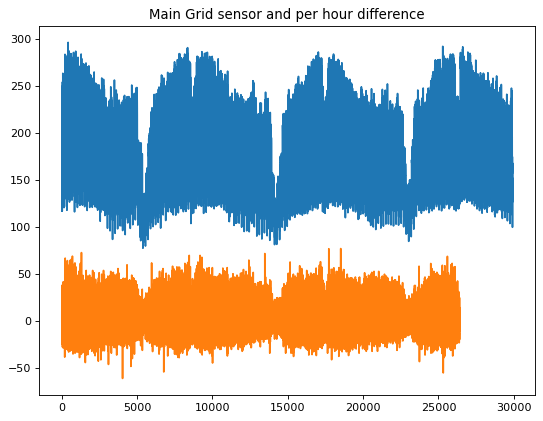

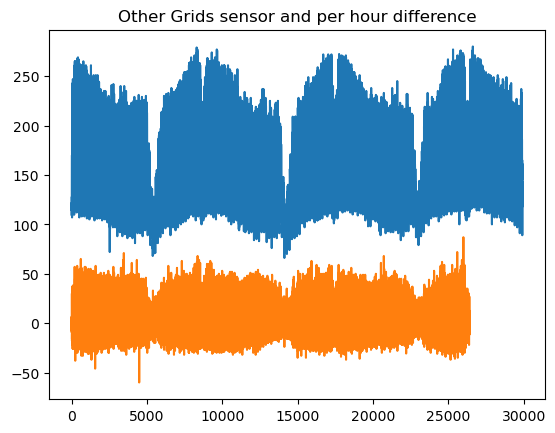

In [5]:
figure(figsize=(8, 6), dpi=80)

plt.plot(df['mainGrid'])  # Mean is constant from the graph 
plt.plot(diffMain) # Mean is near zero here 
plt.title("Main Grid sensor and per hour difference")
plt.show()
plt.plot(df['otherGrids'])  # Mean is constant from the graph 
plt.plot(diffOther) # Mean is near zero here 
plt.title("Other Grids sensor and per hour difference")

plt.show()

## Seems to be stationary 
### Nexts Steps
    * Check for trending 
    * Check for seasonality

## Detrending 

In [191]:
from scipy import signal


In [192]:
detrend = signal.detrend(df['mainGrid'])
detrend_difference  = signal.detrend(diffMain)

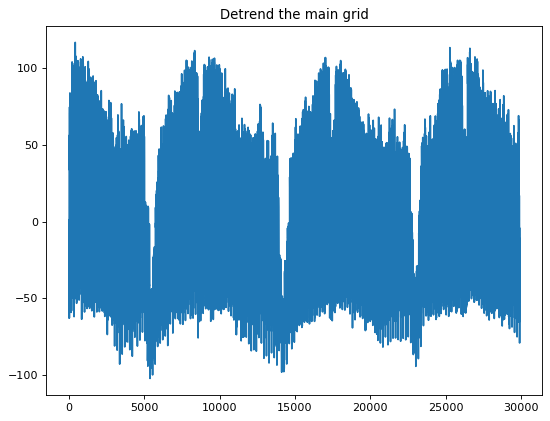

-2.5527116729793495e-14

In [193]:
figure(figsize=(8, 6), dpi=80)

plt.plot(detrend)  # Mean is constant from the graph 

plt.title("Detrend the main grid")
plt.show()
detrend.mean()

The mean is almost at zero  this what happend in detrending 


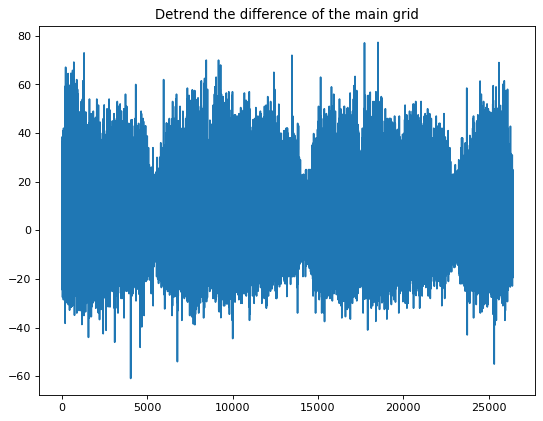

2.0670334131202914e-16

In [9]:
figure(figsize=(8, 6), dpi=80)

plt.plot(detrend_difference)  # Mean is constant from the graph 

plt.title("Detrend the difference of the main grid")
plt.show()
detrend_difference.mean()

Smae for the difference the mean is almost zero 

# Remove Seasonalilty 

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [75]:

df_test = pd.read_csv('powerSupplyStream.csv')
decompose_result = seasonal_decompose(df_test['mainGrid'], model="multiplicative") # It did not work but I will check it later




In [78]:
period = 24 # grouping by day
season_mean = df.groupby(df_test['mainGrid'].index % period).transform('mean')
df_test-= season_mean


/var/folders/bb/p3g4vtcs3bj0121sb3zcr0cc0000gn/T/ipykernel_46370/4014666942.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  season_mean = df.groupby(df_test['mainGrid'].index % period).transform('mean')


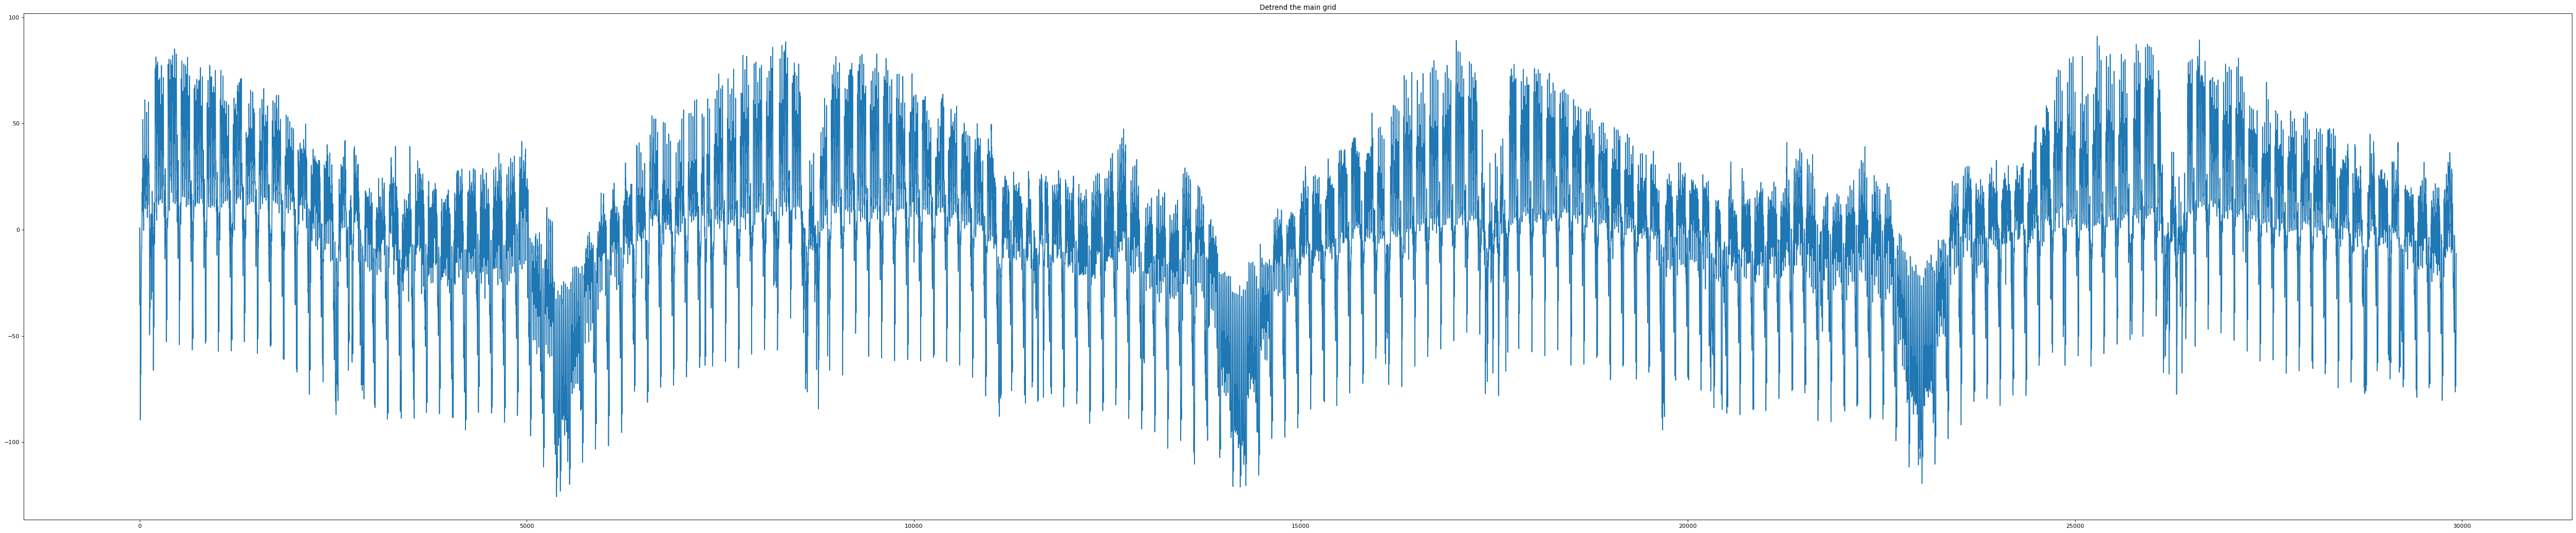

In [81]:
figure(figsize=(80, 16), dpi=80)

plt.plot(df_test['mainGrid'])  # Mean is constant from the graph 

plt.title("Detrend the main grid")
plt.show()

## Check day night shift readings

In [194]:
df = pd.read_csv('powerSupplyStream.csv')
df_day = df[(df['hourOfDay'] > 6) ].reset_index()
df_day = df[(df['hourOfDay']<=17) & (df['hourOfDay'] >= 6)].reset_index()
df_night = df[~((df['hourOfDay']<=17) & (df['hourOfDay'] >= 6))].reset_index()
# df_day = df[df['hourOfDay'] > 15 and df['hourOfDay'] < 6 ].reset_index()
# df_day = df[df['hourOfDay'] <  18].reset_index()
df_night.head(-10)
df_night['hourOfDay'].unique()
df_day['hourOfDay'].unique()


array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

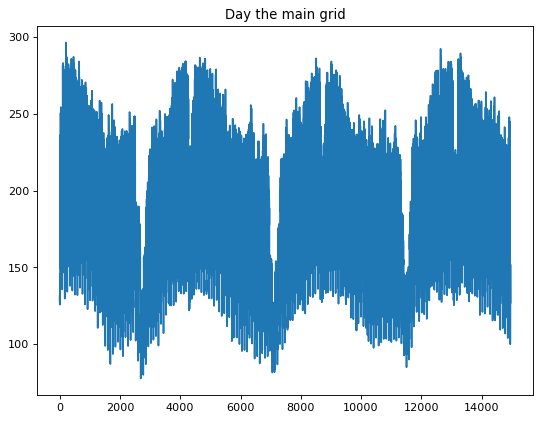

14964

In [195]:
figure(figsize=(8, 6), dpi=80)

plt.plot(df_day['mainGrid'])  # Mean is constant from the graph 

plt.title("Day the main grid")
plt.show()
len(df_day['mainGrid'])

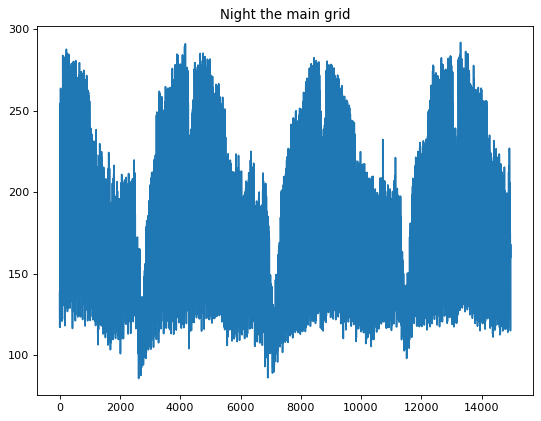

194.43045977011494

In [196]:
figure(figsize=(8, 6), dpi=80)

plt.plot(df_night['mainGrid'])  # Mean is constant from the graph 

plt.title("Night the main grid")
plt.show()
df_Night['mainGrid'].mean()

## There is difference in the readings between day and night shifts from the graphs
### Espically the night shift has different shape than the total dataset

# Now detrending both shifts

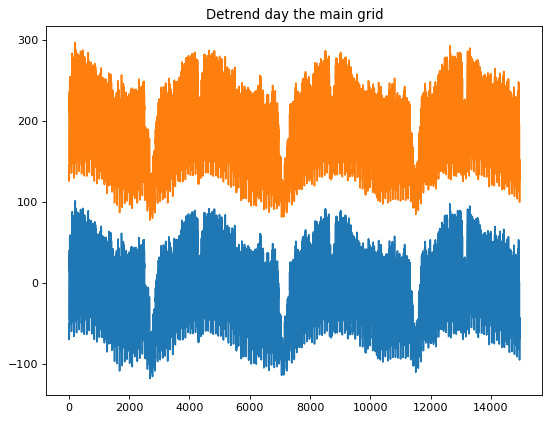

-7.706758098423369e-14

In [170]:
detrend_day = signal.detrend(df_day['mainGrid'])

figure(figsize=(8, 6), dpi=80)

plt.plot(detrend_day) 
plt.plot(df_day['mainGrid']) 

plt.title("Detrend day the main grid")
plt.show()
detrend_day.mean()

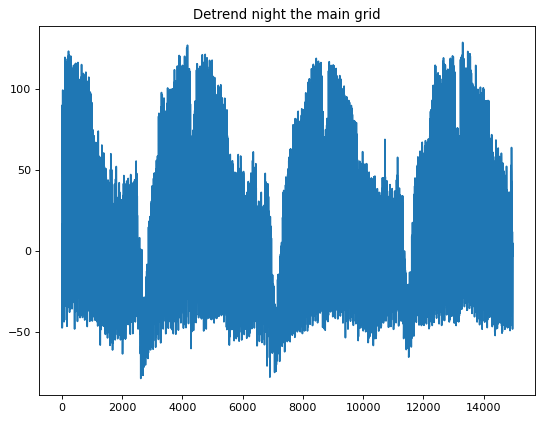

-1.5571541205174032e-13

In [197]:
detrend_night = signal.detrend(df_night['mainGrid'])

figure(figsize=(8, 6), dpi=80)

plt.plot(detrend_night)  # Mean is constant from the graph 

plt.title("Detrend night the main grid")
plt.show()
detrend_night.mean()

# Remove Seasonalilty

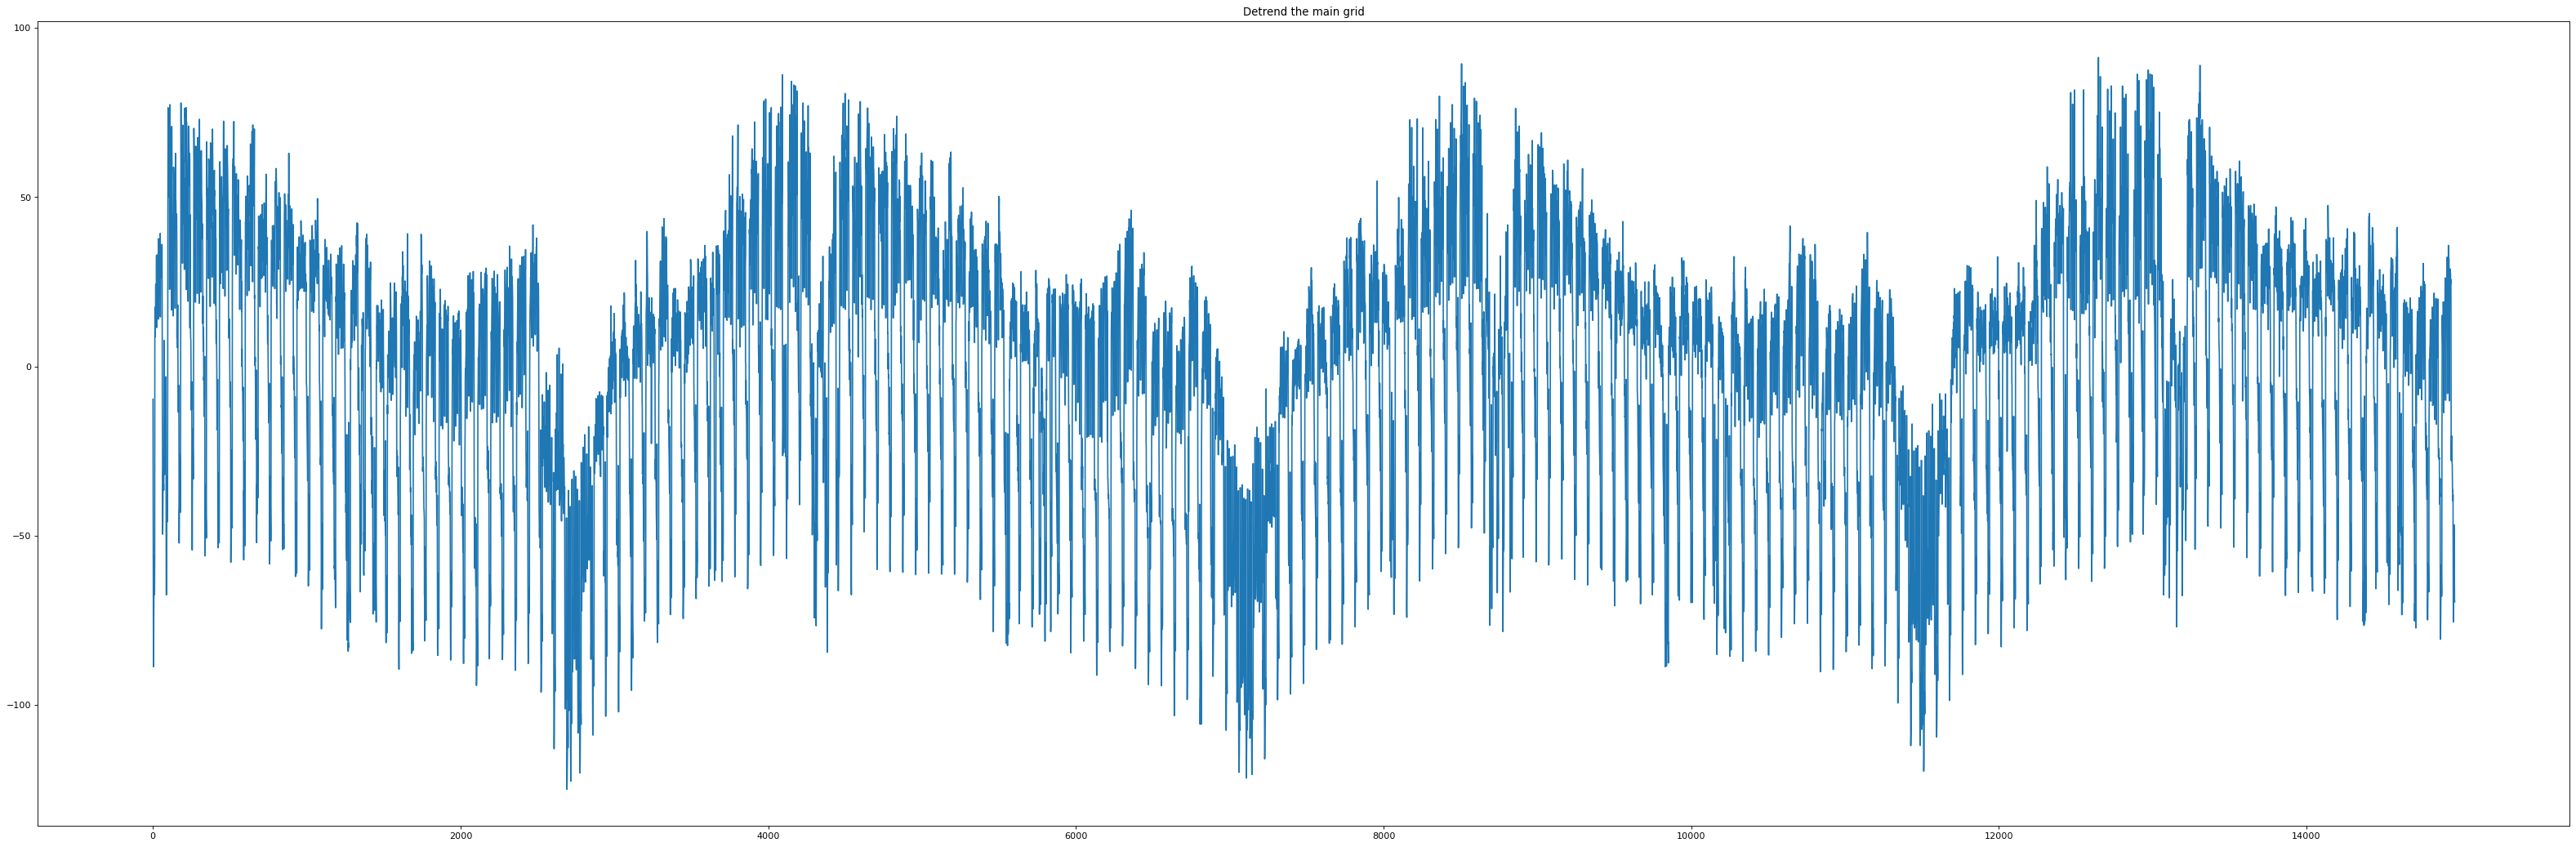

In [202]:
period = 24 # grouping by day
season_mean_day = df_day.groupby(df_day['mainGrid'].index % period).transform('mean')
df_day-= season_mean_day
figure(figsize=(50, 16), dpi=80)

plt.plot(df_day['mainGrid'])  # Mean is constant from the graph 

plt.title("Detrend the main grid")
plt.show()

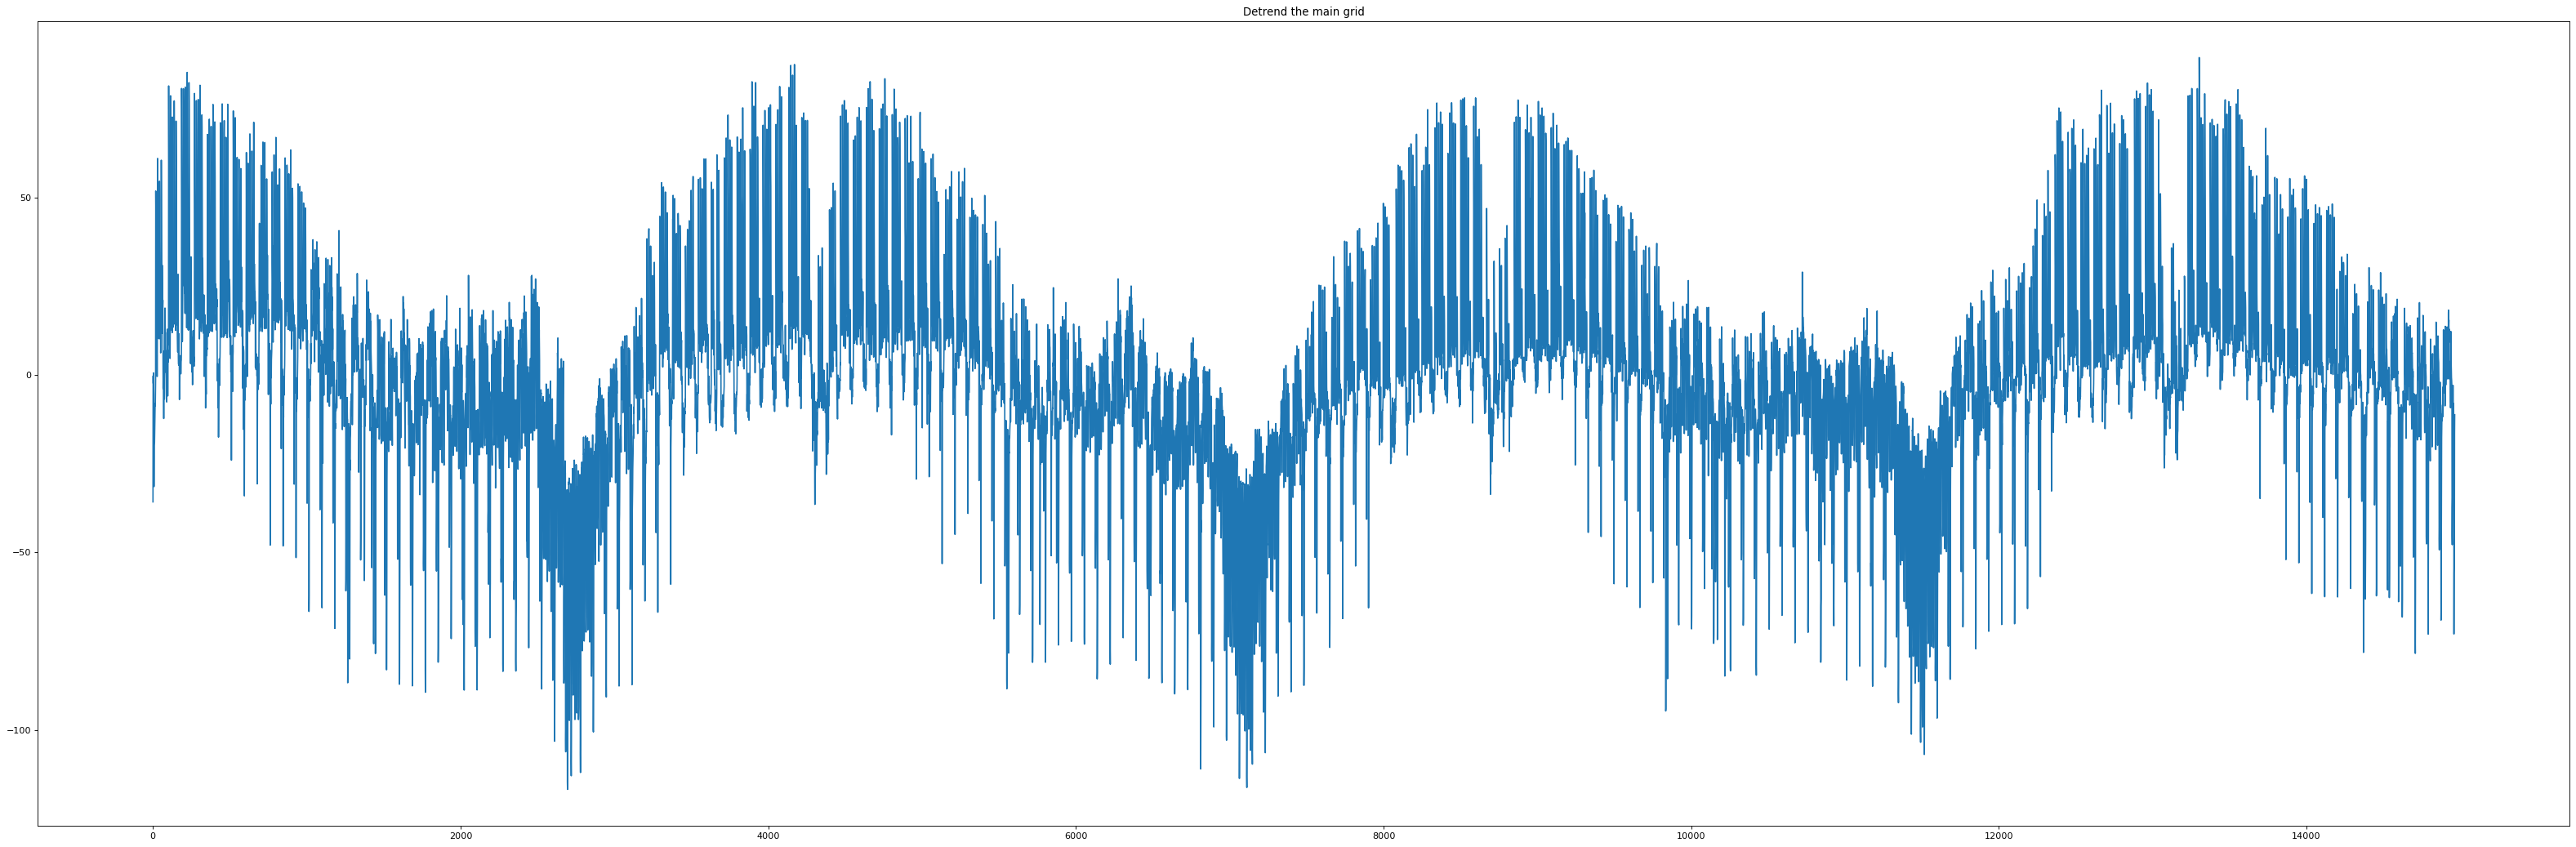

In [203]:
period = 24 # grouping by day
season_mean_nigth = df_night.groupby(df_night['mainGrid'].index % period).transform('mean')
df_night-= season_mean_nigth
figure(figsize=(50, 16), dpi=80)

plt.plot(df_night['mainGrid'])  # Mean is constant from the graph 

plt.title("Detrend the main grid")
plt.show()

# Check the seasons if there is difference 